In [2]:
from NN import *
from LTL import *


from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import os
from matplotlib import pyplot as plt

Number of Omega-automaton states (including the trap state): 5


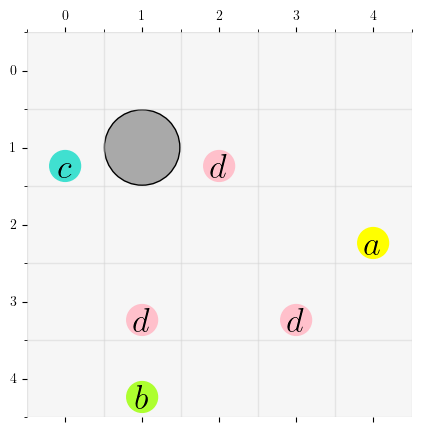

In [2]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ("(G !d) & ((!c) U b) & ((!b) U a) & (F c)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E',  'E'],
['E',  'B',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    (),    (),    ()],
[('c',),(),    ('d',),(),    ()],
[(),    (),    (),    (),    ('a',)],
[(),    ('d',),(),    ('d',),()],
[(),    ('b',),(),    (),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=1, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)


In [3]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 5, 32)     672         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 5, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 200)          0           ['conv2d_1[0][0]']               
                                                                                              

In [4]:
t = "[] ~d /\ (~c % b) /\ (~b % a) /\ (<> c)"

LTL_formula = parser.parse(t)
predicates={'a':[14], 'b':[21], 'c':[5], 'd':[7,16,18]}

In [5]:
LTL_formula

('/\\',
 ('[]', ('~', (None, 'd'))),
 ('/\\',
  ('%', ('~', (None, 'c')), (None, 'b')),
  ('/\\', ('%', ('~', (None, 'b')), (None, 'a')), ('<>', (None, 'c')))))

In [10]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [11]:

num_epochs = 20
training = True
T = 16
results = []
search_depths = [2,4,8,16,32,40,60,80,100,120,200] #[2,4,6,8,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120]
for sd in search_depths:
    wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_epochs):
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=sd,
                verbose=4,start=(0,0),T=T,K=3)
        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1
            print(check_LTL(LTL_formula, trajectory, predicates))

        if training:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)

    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)
    results.append(wins)

trajectory: [0, 0, 5, 5, 10, 11, 12, 13, 14, 9, 14, 14, 19, 24, 19, 24]
action_history: [3, 1, 3, 1, 2, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 2, 0), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 3), (0, 4, 2, 4), (0, 4, 1, 4), (0, 4, 2, 4), (0, 4, 2, 4), (0, 4, 3, 4), (0, 4, 4, 4), (0, 4, 3, 4), (0, 4, 4, 4)]
----------
trajectory: [0, 0, 0, 5, 5, 10, 11, 11, 12, 11, 12, 13, 14, 19, 24, 23]
action_history: [0, 3, 1, 3, 1, 2, 0, 2, 3, 2, 2, 2, 1, 1, 3]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 2, 0), (0, 4, 2, 1), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 3), (0, 4, 2, 4), (0, 4, 3, 4), (0, 4, 4, 4), (0, 4, 4, 3)]
----------
trajectory: [0, 5, 5, 0, 1, 1, 1, 0, 5, 10, 5, 0, 0, 0, 1, 2]
action_history: [1, 3, 0, 2, 1, 0, 3, 1, 1, 0, 0, 0, 3, 2, 2]
state history: [(0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 0, 0), (0, 4, 0, 1), (0, 4, 0, 1), (0, 4,

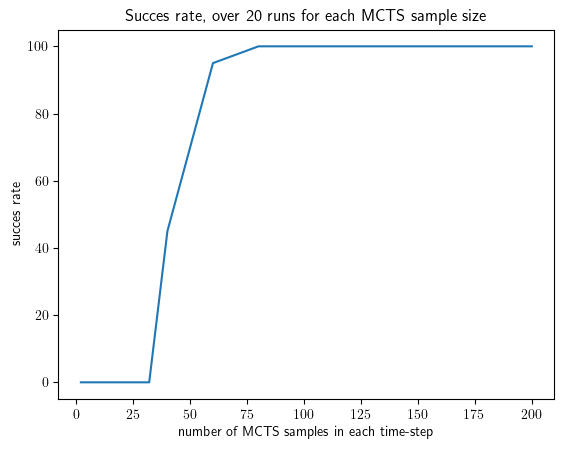

In [13]:
plt.plot(search_depths, [r*5 for r in results])
plt.xlabel("number of MCTS samples in each time-step")
plt.ylabel("succes rate")
plt.title("Succes rate, over 20 runs for each MCTS sample size")
plt.savefig('line_plot2.pdf') 

In [38]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

In [39]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [ ]:
os.system('ffmpeg -r 3 -i ./test/%d.png -vcodec libx264 -y ./test/test.mp4')

1

In [38]:
np.array([0, 14, 85, 86, 80, 85, 83, 85])/87

array([0.        , 0.16091954, 0.97701149, 0.98850575, 0.91954023,
       0.97701149, 0.95402299, 0.97701149])

In [3]:
T = [10, 20, 30, 40, 50, 60, 80, 100, 200, 400]
# success_rates= [0.0, 5.0, 10.0, 14.0, 15.0, 17.0, 17.0]
success_rates= [97, 100, 100, 100, 100, 100, 100, 100, 100, 100,]
succes_std = []
for i in success_rates:
    temp = np.zeros(100)
    temp[:int(i)]=1
    std = np.sqrt(100*np.var(temp))
    succes_std.append((i-std, i+std))

In [4]:
len(T), len(success_rates)

(10, 10)

[97, 100, 100, 100, 100, 100, 100, 100, 100, 100]

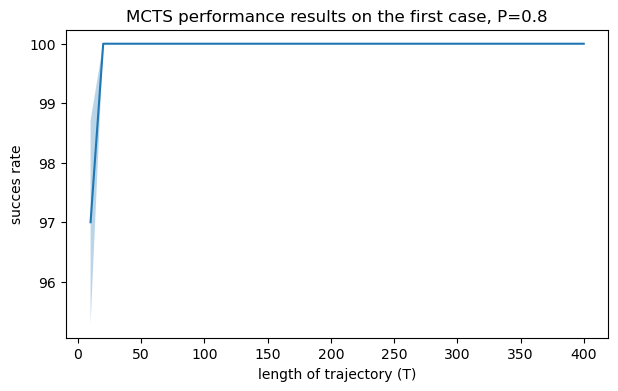

In [5]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate")
plt.title("MCTS performance results on the first case, P="+str(0.8))
success_rates

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

C:\Users\pc-admin\AppData\Local\Temp\ipykernel_21148\2869943138.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


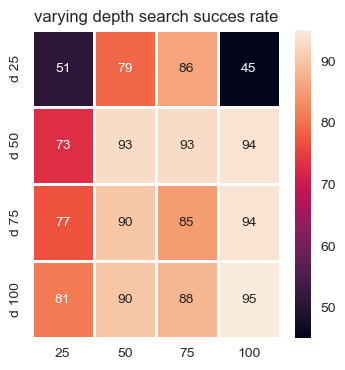

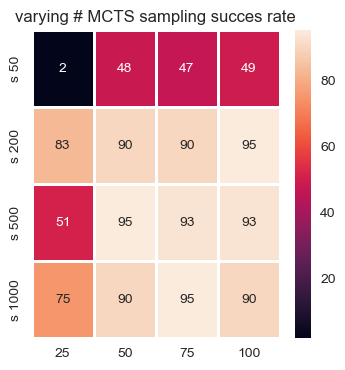

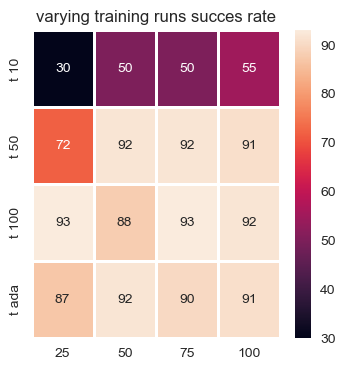

In [17]:
plt.style.use("seaborn")
 
# 2. Generate a 10x10 random integer matrix
data = [
    [51, 79, 86, 45],
    [73, 93, 93, 94],
    [77, 90, 85, 94],
    [81, 90, 88, 95]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['d 25', 'd 50', 'd 75', 'd 100'])
plt.title("varying depth search succes rate")
plt.show()

data = [
    [2, 48, 47, 49],
    [83, 90, 90, 95],
    [51, 95, 93, 93],
    [75, 90, 95, 90]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['s 50','s 200', 's 500', 's 1000'])
plt.title("varying # MCTS sampling succes rate")
plt.show()

data = [
    [30, 50, 50, 55],
    [72, 92, 92, 91],
    [93, 88, 93, 92],
    [87, 92, 90, 91],
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['t 10', 't 50', 't 100', 't ada'])
plt.title("varying training runs succes rate")
plt.show()

C:\Users\pc-admin\AppData\Local\Temp\ipykernel_21148\908381384.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


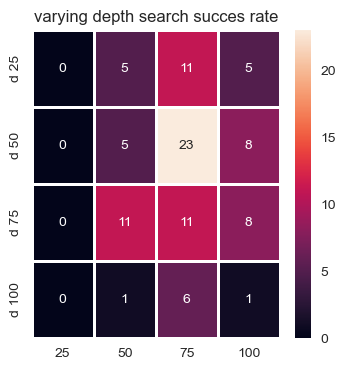

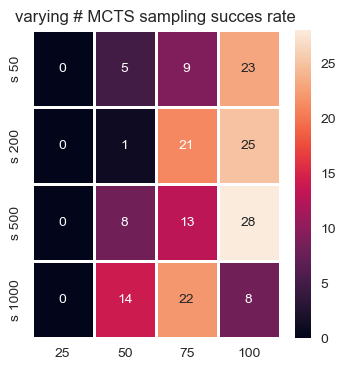

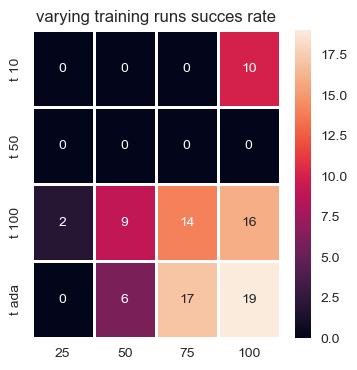

In [19]:
plt.style.use("seaborn")
 
# 2. Generate a 10x10 random integer matrix
data = [
    [0, 5, 11, 5],
    [0, 5, 23, 8],
    [0, 11, 11, 8],
    [0, 1, 6, 1]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['d 25', 'd 50', 'd 75', 'd 100'])
plt.title("varying depth search succes rate")
plt.show()

data = [
    [0, 5, 9, 23],
    [0, 1, 21, 25],
    [0, 8, 13, 28],
    [0, 14, 22, 8]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['s 50','s 200', 's 500', 's 1000'])
plt.title("varying # MCTS sampling succes rate")
plt.show()

data = [
    [0, 0, 0, 10],
    [0, 0, 0, 0],
    [2, 9, 14, 16],
    [0, 6, 17, 19],
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['t 10', 't 50', 't 100', 't ada'])
plt.title("varying training runs succes rate")
plt.show()